# Analysis of Telco Data for churning



#Download Telco data

In [1]:
!pip install imblearn
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
#1. Read the telco data from kaggle
#Had issue with reading data from the url , adding the suffix ?raw=True at the of the URL did the magic
url= "https://github.com/alamurm/pixelTest/blob/main/case_study/Telco_Churn/Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv?raw=True"
ds= pd.read_csv (url, sep =',', on_bad_lines = 'skip')



---



#EDA Exploratory Data Analysis


In [2]:
#2. Exploratory data analysis

#understand the dataset
print(ds.info())
print('\n Data dimension', ds.shape)
print(ds.describe())
#check for the missing information
print('\n', ds.isna().sum())

#check availability of data in total charges column
missingTotalCharge = ds.loc[ds['TotalCharges']== " "]
print(missingTotalCharge.shape)
print(missingTotalCharge[["tenure", "Contract", "TotalCharges"]])

#Analyse the value in the target column "Churn"
ds['Churn'].value_counts().to_frame().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn,No,Yes
count,5174,1869


In [3]:
#Intialize the global variables
#different models to evaluate the classification problem
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

TARGET = 'Churn'
RECALL = 'recall'
PRECISION= 'precision'
F1SCORE = 'f1-score'
ACCURACY= 'Accuracy'

CAT_FEATURES =ds.select_dtypes(exclude=['number']).columns
CAT_FEATURES=CAT_FEATURES.drop(['customerID', 'TotalCharges']).tolist()
NUM_FEATURES= ds.select_dtypes(include=['number']).columns.tolist()
NUM_FEATURES.remove('SeniorCitizen')

#Create a dataframe to store the metrics to compare across different Models
#classifierAlgorithms=[LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]
ALGORITHMS_TO_EVALUATE=['LogisticRegression','DecisionTree', 'RandomForest']

METRICS_TO_COMPARE = [ACCURACY, PRECISION, RECALL,F1SCORE ]
metricDict={}
for metric in METRICS_TO_COMPARE:
  metricDict[metric]=0.0

metricsData=[]
for alg in ALGORITHMS_TO_EVALUATE:
    metricsData.append(metricDict)
print(metricsData)

modelMetrics_df= pd.DataFrame(metricsData, index=ALGORITHMS_TO_EVALUATE )
print(modelMetrics_df)

[{'Accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, {'Accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}, {'Accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}]
                    Accuracy  precision  recall  f1-score
LogisticRegression       0.0        0.0     0.0       0.0
DecisionTree             0.0        0.0     0.0       0.0
RandomForest             0.0        0.0     0.0       0.0




---



#Visual Data Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

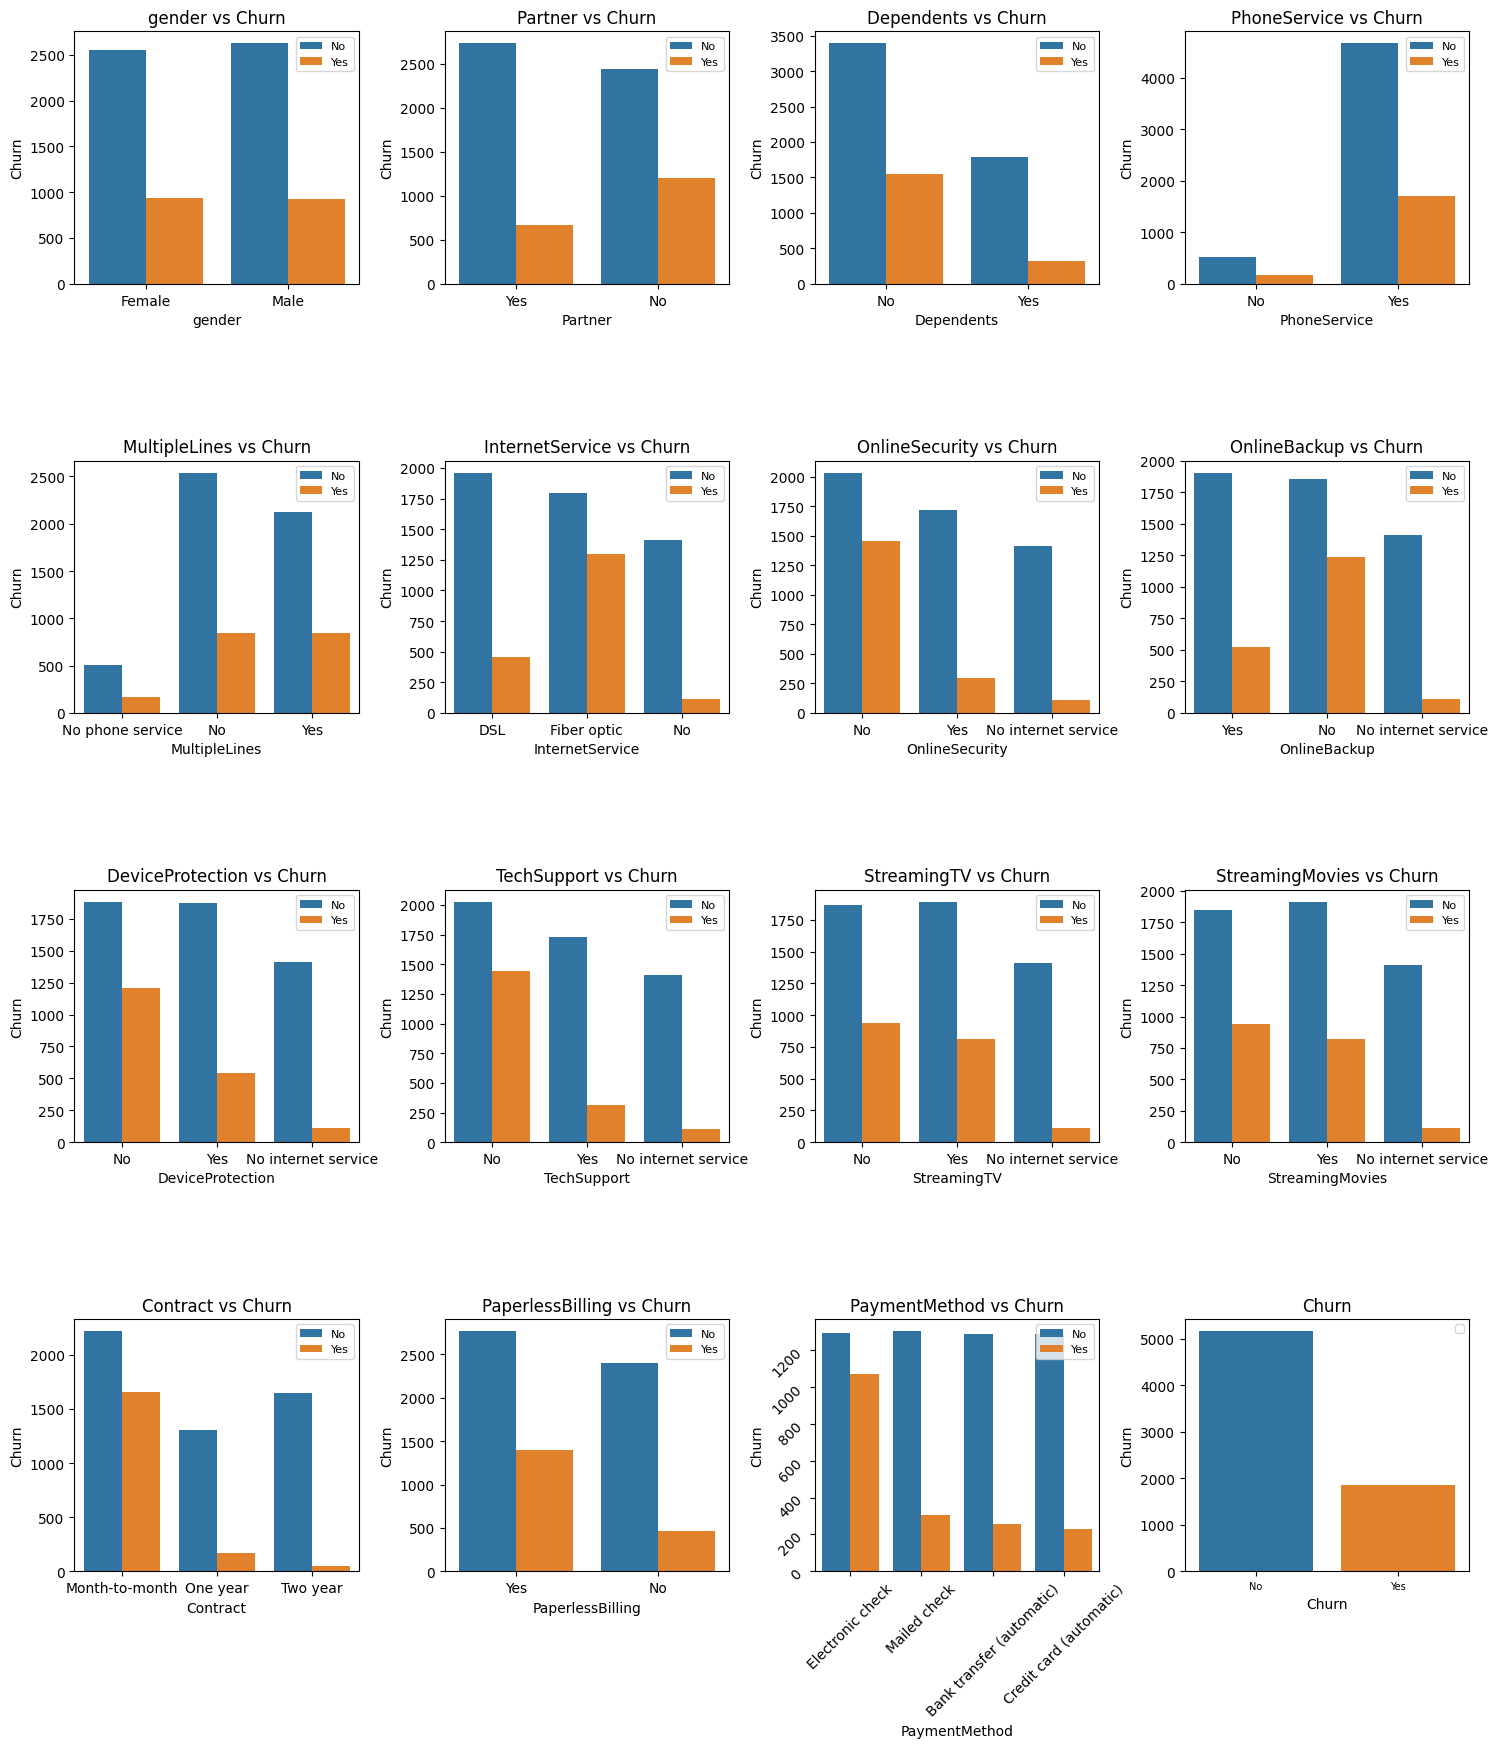

In [10]:
#2 Visual Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

fig , ax = plt.subplots(4,4,figsize = (18,20))
fig.subplots_adjust(wspace=0.3, hspace=0.7)
fig.subplots


for cat, subplot in zip(CAT_FEATURES, ax.flatten()) :
  subplot.set_ylabel(TARGET)
  if (cat != TARGET) :
    subplot.title.set_text(cat + ' vs '+ TARGET)
  else :
    subplot.title.set_text(TARGET)

  sns.countplot(data=ds, x=cat,hue = TARGET, ax = subplot)
  subplot.legend(loc=1, prop={'size': 8})
  plt.xticks(fontsize =7)
  if cat =='PaymentMethod':
    subplot.tick_params(labelrotation=45)



plt.show


	 Min:0.00  Max:72.00  Median:29.00
	 Min:18.25  Max:118.75  Median:70.35


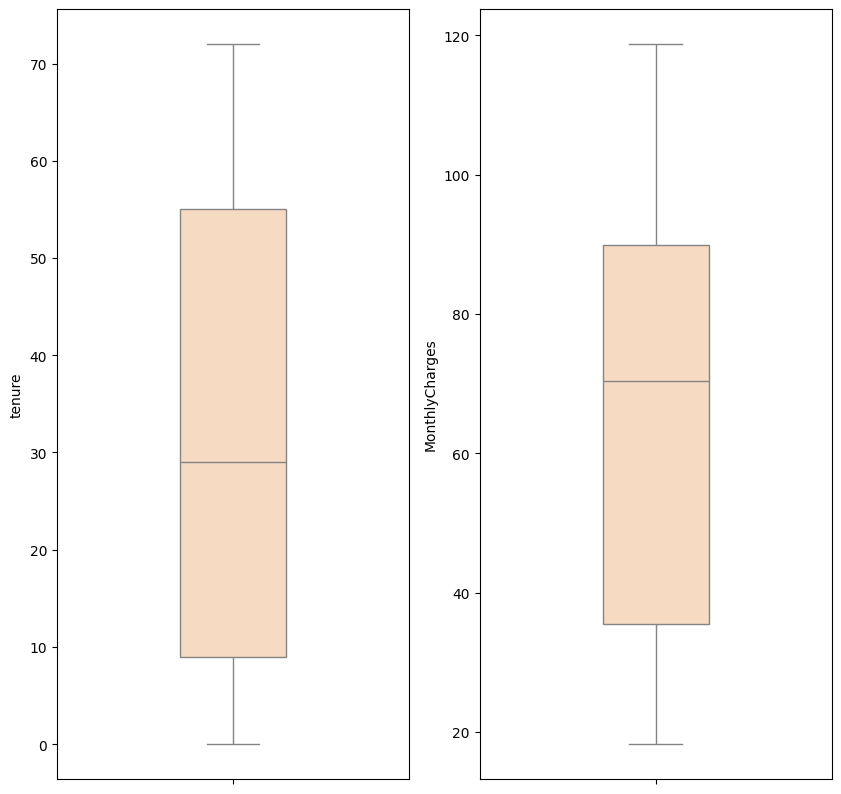

In [5]:
#2 Visual Data analysis contd..
#Boxplot the numerical fatures to identify for any outliers
from pandas.api.types import is_numeric_dtype
fig,ax=plt.subplots(1,2,figsize=(10,10))
#Box plots for numerical features to find outliers if any
for feature, subplot in zip(NUM_FEATURES, ax.flatten()):
  if not is_numeric_dtype(ds[feature]) :
    charges =pd.to_numeric(ds[feature], errors='coerce')
  else :
    charges =ds[feature]
  strStat= f'Min:{charges.min():.2f}  Max:{charges.max():.2f}  Median:{charges.median():.2f}'
  print("\t",strStat)
  sns.boxplot(charges, width=0.3, color='peachpuff' , ax= subplot)
plt.show()




---



#Data Preprocessing

In [4]:
#This function prepares the Telco data for ML algorithms
from sklearn.preprocessing import LabelEncoder
def wrangle(ds):
  ds=ds.loc[ds['TotalCharges']!= " "]
  #Convert the numerical columns
  ds['TotalCharges']= pd.to_numeric(ds['TotalCharges'])
  print(type(NUM_FEATURES))
  NUM_FEATURES.append('TotalCharges')
  #Customer ID could be dropper
  ds.drop('customerID', axis=1, inplace= True)

  #Encode the target Vriables
  enc=LabelEncoder()
  ds[TARGET]=enc.fit_transform(ds[TARGET])
  #Encode the other caegorical columns
  ds=pd.get_dummies(ds, dtype=int)

  return ds
encoded_ds = wrangle (ds)

<class 'list'>




---



<Axes: >

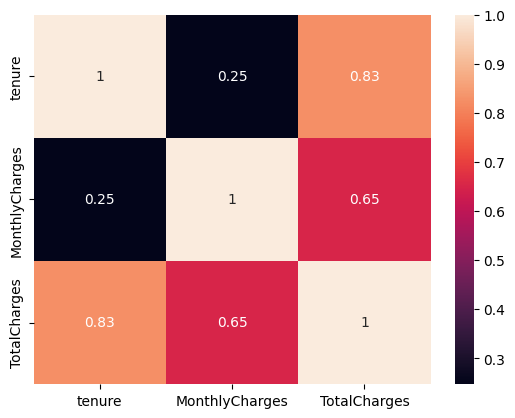

In [7]:
#Visual Disply to show the correlation between numerical columns
sns.heatmap(encoded_ds[NUM_FEATURES].corr(),annot=True )




---



#Split the data for training and testing

In [5]:
#3. Train test split data for ML algorithms
from sklearn.model_selection import train_test_split
y=encoded_ds[TARGET]
X=encoded_ds.drop(TARGET, axis=1)
X_train,  X_test,y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(5274, 45) (5274,) (1758, 45) (1758,)




---



#Helper function to display the classfication metrics and their graph

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#Display clasification metrics
def classificationMetrics(trainedModel):
  fig,ax=plt.subplots(1,len(trainedModel),figsize=(8,8))
  fig.subplots_adjust(wspace=0.5)
  fig.tight_layout()
  for model, subplot in zip(trainedModel, ax.flatten()):
    pred= model.predict(X_test)
    accuracy = round(accuracy_score(y_test, pred)*100,2)
    searchIndex='RandomForest'
    if isinstance(model, LogisticRegression):
      searchIndex='LogisticRegression'
    elif isinstance(model, DecisionTreeClassifier):
      searchIndex = 'DecisionTree'
    report= classification_report(y_test, pred, output_dict=True)
    modelMetrics_df.loc[searchIndex, ACCURACY] = accuracy
    modelMetrics_df.loc[searchIndex, PRECISION] = round(report['1'][PRECISION] *100,2)
    modelMetrics_df.loc[searchIndex, RECALL] = round(report['1'][RECALL] *100,2)
    modelMetrics_df.loc[searchIndex, F1SCORE] = round(report['1'][F1SCORE] *100,2)
    cmatrix =confusion_matrix(y_test, pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['No', 'Yes'])
    cm_display.plot(ax=subplot, colorbar=False)
    subplot.title.set_text(type(model).__name__[:5])
  plt.show()
  print('Baseline accuracy : ', round(baseline_accuracy*100,2))
  print(modelMetrics_df)


In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def calculateROC(models):
  for model in models:
    Y_prob=model.predict_proba(X_test)
    fpr, tpr, thresold =roc_curve(y_test, Y_prob[:,1])
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr, tpr, label =f'{model} with roc {roc_auc:.2f}')

In [8]:
#Calculate baseline accuracy
from sklearn.metrics import accuracy_score
y_pred_baseline = [y_train.mode()]*len(y_train)
baseline_accuracy = accuracy_score(y_train,y_pred_baseline )


#Classification models using 3 Algorithms

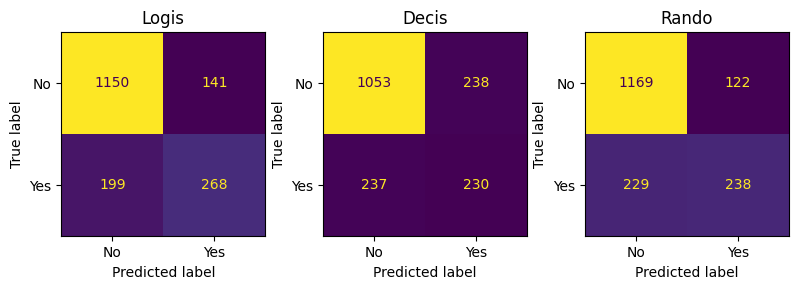

Baseline accuracy :  73.42
                    Accuracy  precision  recall  f1-score
LogisticRegression     80.66      65.53   57.39     61.19
DecisionTree           72.98      49.15   49.25     49.20
RandomForest           80.03      66.11   50.96     57.56


In [22]:
#Train the models and display the metrics
classifierAlgorithms=[LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(max_depth=7)]
trainedModel =[]
for classifier in classifierAlgorithms:
  model=classifier.fit(X_train, y_train)
  trainedModel.append(model)
classificationMetrics(trainedModel)

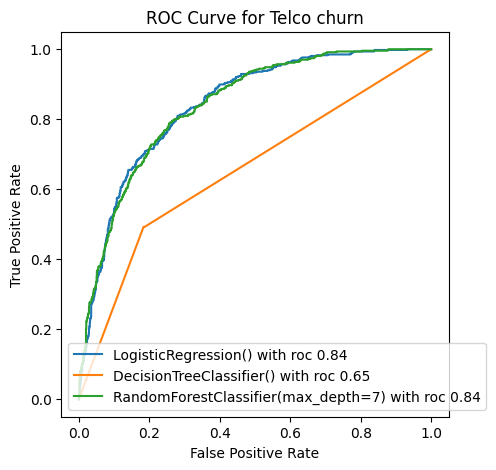

In [23]:
#5 plot the roc for trained models
plt.figure(figsize=(5,5), dpi=100)
calculateROC(trainedModel)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telco churn')
plt.legend()
plt.show()

#SMOTE for class imbalance

In [24]:

# import SMOTE for sampling
from imblearn.over_sampling import SMOTE
print(f'Pre over sampling Churn count   {sum(y_train==1)}')
print(f'pre over sampling NoChurn count {sum(y_train==0)}')

sm= SMOTE(sampling_strategy=0.5, random_state=20,k_neighbors=5)
X_train_res, Y_train_res=sm.fit_resample(X_train, y_train.ravel())

print(f'over sampling Churn count   {sum(Y_train_res==1)}')
print(f'over sampling NoChurn count {sum(Y_train_res==0)}')

Pre over sampling Churn count   1402
pre over sampling NoChurn count 3872
over sampling Churn count   1936
over sampling NoChurn count 3872


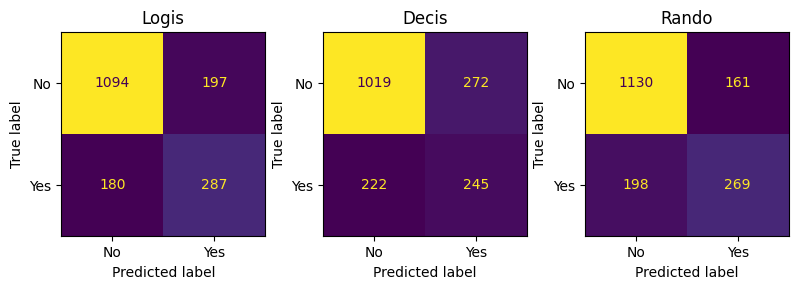

Baseline accuracy :  73.42
                    Accuracy  precision  recall  f1-score
LogisticRegression     78.56      59.30   61.46     60.36
DecisionTree           71.90      47.39   52.46     49.80
RandomForest           79.58      62.56   57.60     59.98


In [14]:
#Train the models and display the metrics with smote samples
trainedModel =[]
for classifier in classifierAlgorithms:
  model=classifier.fit(X_train_res, Y_train_res)
  trainedModel.append(model)
classificationMetrics(trainedModel)
#Metric Recall is better after SMOTE

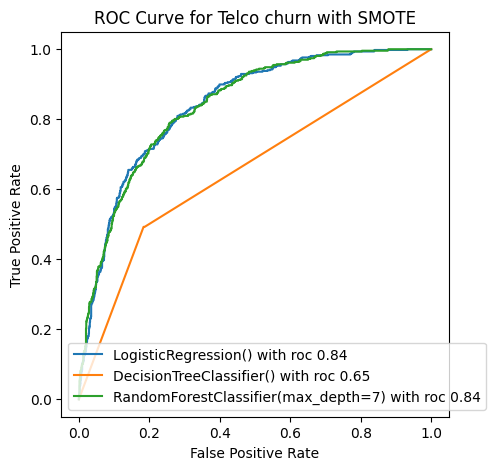

In [25]:

#5 plot the roc for trained models
plt.figure(figsize=(5,5), dpi=100)
calculateROC(trainedModel)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Telco churn with SMOTE')
plt.legend()
plt.show()

In [26]:
#6 cross validation with the same data with 5 Folds with oversampled data
from sklearn.model_selection import cross_val_score

print(f'Pre over sampling Churn count   {sum(y==1)}')
print(f'pre over sampling NoChurn count {sum(y==0)}')

sm= SMOTE(sampling_strategy=0.5, random_state=20,k_neighbors=5)
X_res, Yres=sm.fit_resample(X, y.ravel())

print(f'over sampling Churn count   {sum(Y_train_res==1)}')
print(f'over sampling NoChurn count {sum(Y_train_res==0)}')
for classifier in classifierAlgorithms:
  cv_score = cross_val_score(classifier, X, y, cv= 5)
  print(cv_score)
  accuracy = (sum(cv_score)/len(cv_score))*100
  print("The accuracy score of the model ", classifier, ' = ',   round(accuracy,2))

Pre over sampling Churn count   1869
pre over sampling NoChurn count 5163
over sampling Churn count   1936
over sampling NoChurn count 3872
[0.80312722 0.8137882  0.79089616 0.80938834 0.80440967]
The accuracy score of the model  LogisticRegression()  =  80.43
[0.71783937 0.73489694 0.72190612 0.72688478 0.73541963]
The accuracy score of the model  DecisionTreeClassifier()  =  72.74
[0.80881308 0.81094527 0.78093883 0.8086771  0.80014225]
The accuracy score of the model  RandomForestClassifier(max_depth=7)  =  80.19


In [18]:
#Implement GridSearchCV
from sklearn.model_selection import GridSearchCV
param ={
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,1000,2000]}

model= LogisticRegression()
classifier = GridSearchCV(model, param, cv=5)
classifier.fit(X_train_res, Y_train_res)
print(classifier.best_params_)
print(f'{classifier.estimator} with {classifier.best_params_} gives the best accuracy : {classifier.best_score_*100:.2f}%')


{'max_iter': 100, 'solver': 'newton-cg'}
LogisticRegression() with {'max_iter': 100, 'solver': 'newton-cg'} gives the best accuracy : 81.30%


{'0': {'precision': 0.8536404160475483, 'recall': 0.8900077459333849, 'f1-score': 0.8714448236632537, 'support': 1291.0}, '1': {'precision': 0.6553398058252428, 'recall': 0.5781584582441114, 'f1-score': 0.6143344709897611, 'support': 467.0}, 'accuracy': 0.8071672354948806, 'macro avg': {'precision': 0.7544901109363955, 'recall': 0.7340831020887482, 'f1-score': 0.7428896473265074, 'support': 1758.0}, 'weighted avg': {'precision': 0.8009632914890633, 'recall': 0.8071672354948806, 'f1-score': 0.8031453158711485, 'support': 1758.0}}


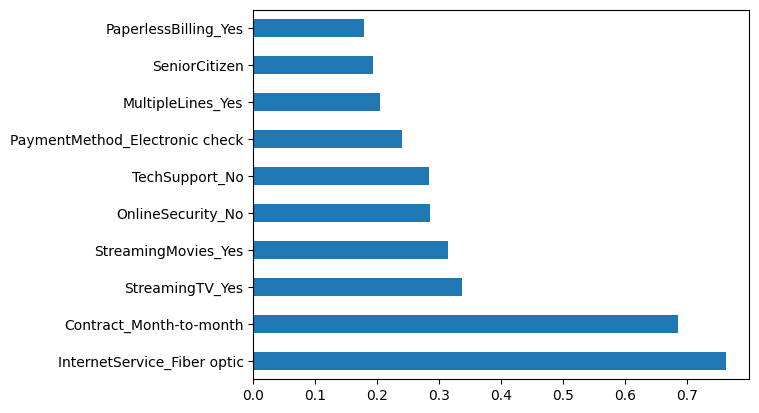

In [30]:
# Coefficients
model= LogisticRegression(max_iter= 100, solver= 'newton-cg')
model.fit(X_train, y_train)
coefficients = model.coef_[0]
pred=model.predict(X_test)
report= classification_report(y_test, pred, output_dict=True)
print(report)
# Display feature importance using coefficients and odds ratios
feature_importance = pd.Series(coefficients, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()
